# Beautiful NYT Bestselling Soup
Exploring Beautiful Soup by scraping the NYT bestsellers list

In [20]:
# import needed libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import datetime as DT

In [21]:
def get_nyt_data(year, month, day):
    """
    This function takes in a date in integer (year, month, day) format and scrapes 
    the NYT bestsellers list from that date. Returns a final list in the form:
    [[date, rank, category, title, author, # weeks on list, description]]
    """

    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", 
    "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
    "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    # standardize date format with leading zeros if needed for the URL
    if (int(month) < 10):
        month = "0" + month
    if (int(day) < 10):
        day = "0" + day

    # request current dates NYT page for scraping
    response = requests.get("https://www.nytimes.com/books/best-sellers/" + year + "/" +  month + "/" + day, headers=headers)
    content = response.content
    soup = BeautifulSoup(content, features='lxml')

    # standardize date format
    date = str(year) + "-" + str(month) + "-" + str(day)
    rank = 1 # rank/5 for each book in the category
    categoryNum = 0
    
    FinalList = []
    categoryList = []

    # category was in a separate css section from rest of data
    # so we need to get all of this data first
    for c in soup.findAll('section', attrs={'class':'e8j42380'}):
        category = c.find('a', attrs={'class':'css-nzgijy'})
        categoryList.append(category.text)


    # grab the rest of the data, clean it, and add each row to FinalList
    for d in soup.findAll('a', attrs={'class':'css-g5yn3w'}):
        title = d.find('h3', attrs={'class':'css-i1z3c1'})
        author = d.find('p', attrs={'class':'css-1nxjbfc'})
        description = d.find('p', attrs={'class':'css-5yxv3r'})
        weeks = d.find('p', attrs={'class':'css-t7cods'})
        
        workingList = []
        workingList.append(date)
        workingList.append(rank)
        rank += 1

        workingList.append(categoryList[categoryNum])

        # all categories are grabbed first and then the rest of the data,
        # we need to keep categoryNum and rank consistent across all inputs
        if rank == 6:
            categoryNum += 1
            rank = 1

        # input all of the data into our workingList 
        # to append each row to FinalList
        if title is not None:
            workingList.append(title.text.title())
        else:
            workingList.append('Unknown')
        

        if author is not None:
            authors = author.text.split()
            # majority of text begins with "by AUTHOR NAME"
            # but some begin with "Written and Illustrated by AUTHOR NAME"
            if authors[0] == "written":
                workingList.append(authors[len(authors) - 2] + " " + authors[len(authors) - 1])
            else:
                workingList.append(author.text[3:])
        else:
            workingList.append('Unknown')

        # book that are new on the list this week do not list 0 or 1
        # they are listed as "New", so append 1 when "New" is found
        if weeks is not None:
            weeksOnList = weeks.text.split()
            if weeksOnList[0] == "New":
                workingList.append(1)
            else:
                workingList.append(weeksOnList[0])
        else:
            workingList.append('Unknown')
        

        if description is not None:
            if description.text == '':
                workingList.append("Unknown")
            else:
                workingList.append(description.text)
        else:
            workingList.append('Unknown')

        # append newly generated and cleaned row to the FinalList
        FinalList.append(workingList)
    
    return FinalList

In [22]:
# how many weeks would you like to get data from
weeksToSearch = 10

# search backwards from this date (year, month, day) 
# must be +- 7 days from this date exactly
curDate = DT.date(2021, 7, 18)

results = []
for i in range(weeksToSearch):
    results.append(get_nyt_data(str(curDate.year), str(curDate.month), str(curDate.day)))
    curDate = curDate - DT.timedelta(days = 7)

# transform data to work with pandas dataframe
results2 = [item for sublist in results for item in sublist]

# Input results into dataframe and output to .csv file
df = pd.DataFrame(results2, columns=['Date', 'Rank', 'Category', 'Title', 'Author', 'Weeks_on_List', 'Description'])
df.to_csv('nyt_books.csv', index=False, encoding='utf-8')

df = pd.read_csv('nyt_books.csv')

In [23]:
# now let's do some exploratory data analysis.
# first, to get an idea of the size of our data, print the (row, col) shape of it
print("current size of database (rows, columns):", df.shape)
df

current size of database (rows, columns): (550, 7)


,Date,Rank,Category,Title,Author,Weeks_on_List,Description
0,2021-07-18,1,Combined Print & E-Book Fiction,Once Upon A Time In Hollywood,Quentin Tarantino,1,"A novelization of the film set in 1969, by its..."
1,2021-07-18,2,Combined Print & E-Book Fiction,The Last Thing He Told Me,Laura Dave,9,Hannah Hall discovers truths about her missing...
2,2021-07-18,3,Combined Print & E-Book Fiction,Malibu Rising,Taylor Jenkins Reid,5,An epic party has serious outcomes for four fa...
3,2021-07-18,4,Combined Print & E-Book Fiction,The President'S Daughter,Bill Clinton and James Patterson,4,"Matthew Keating, a past president and former N..."
4,2021-07-18,5,Combined Print & E-Book Fiction,Where The Crawdads Sing,Delia Owens,137,In a quiet town on the North Carolina coast in...
...,...,...,...,...,...,...,...
545,2021-05-16,1,Young Adult Hardcover,Rule Of Wolves,Leigh Bardugo,5,The second book in the King of Scars duology.
546,2021-05-16,2,Young Adult Hardcover,Firekeeper'S Daughter,Angeline Boulley,7,Daunis investigates a deadly new drug being di...
547,2021-05-16,3,Young Adult Hardcover,Stamped,Jason Reynolds and Ibram X. Kendi,58,An exploration of racism and antiracism in Ame...
548,2021-05-16,4,Young Adult Hardcover,One Of Us Is Lying,Karen M. McManus,170,"For five students, a detour into detention end..."


In [24]:
# which books are the most popular? Let's get an idea about it by
# creating a new data variable (so that our original data is kept)
# and sorting the values by Weeks_on_List in descending order

data = df
data = data.sort_values(["Weeks_on_List"], axis=0, ascending=False)
data

,Date,Rank,Category,Title,Author,Weeks_on_List,Description
46,2021-07-18,2,Children’s Series,Diary Of A Wimpy Kid,Jeff Kinney,642,The travails and challenges of adolescence.
45,2021-07-18,1,Children’s Series,Harry Potter,J.K. Rowling,641,A wizard hones his conjuring skills in the ser...
101,2021-07-11,2,Children’s Series,Diary Of A Wimpy Kid,Jeff Kinney,641,The travails and challenges of adolescence.
156,2021-07-04,2,Children’s Series,Diary Of A Wimpy Kid,Jeff Kinney,640,The travails and challenges of adolescence.
102,2021-07-11,3,Children’s Series,Harry Potter,J.K. Rowling,640,A wizard hones his conjuring skills in the ser...
...,...,...,...,...,...,...,...
388,2021-05-30,4,Combined Print & E-Book Fiction,That Summer,Jennifer Weiner,1,Daisy Shoemaker receives emails intended for a...
389,2021-05-30,5,Combined Print & E-Book Fiction,People We Meet On Vacation,Emily Henry,1,Opposites Poppy and Alex meet to vacation toge...
391,2021-05-30,2,Combined Print & E-Book Nonfiction,Yearbook,Seth Rogen,1,"A collection of personal essays by the actor, ..."
392,2021-05-30,3,Combined Print & E-Book Nonfiction,Billie Eilish,Billie Eilish,1,A memoir by the multiple Grammy Award-winning ...


In [25]:
# so we can read the data a bit easier, let's remove duplicate values.
# Because we sorted by descending previously, drop_duplicates will
# keep the first value it finds, so we keep the most recent row of each title.

data = data.drop_duplicates(subset=['Title'])
data

,Date,Rank,Category,Title,Author,Weeks_on_List,Description
46,2021-07-18,2,Children’s Series,Diary Of A Wimpy Kid,Jeff Kinney,642,The travails and challenges of adolescence.
45,2021-07-18,1,Children’s Series,Harry Potter,J.K. Rowling,641,A wizard hones his conjuring skills in the ser...
49,2021-07-18,5,Children’s Series,Percy Jackson & The Olympians,Rick Riordan,578,A boy battles mythological monsters.
99,2021-07-11,5,Children’s Picture Books,Dragons Love Tacos,Adam Rubin. Illustrated by Daniel Salmieri,314,What to serve your dragon-guests.
36,2021-07-18,2,Children’s Middle Grade Hardcover,Wonder,R.J. Palacio,303,A boy with a facial deformity starts school.
...,...,...,...,...,...,...,...
308,2021-06-13,4,"Advice, How-To & Miscellaneous",The Menopause Manifesto,Jen Gunter,1,Unknown
338,2021-06-06,4,Combined Print & E-Book Nonfiction,Noise,"Daniel Kahneman, Olivier Sibony and Cass R. Su...",1,What might cause variability in judgments that...
362,2021-06-06,3,"Advice, How-To & Miscellaneous",You Will Get Through This Night,Daniel Howell,1,Unknown
373,2021-06-06,4,Children’s Picture Books,Shady Baby,Gabrielle Union-Wade and Dwyane Wade Jr. Illus...,1,Kaavia speaks up for what's right!


In [26]:
# Let's look at the top 20 rows to see what books and categories have longevity of popularity
data.head(20)

,Date,Rank,Category,Title,Author,Weeks_on_List,Description
46,2021-07-18,2,Children’s Series,Diary Of A Wimpy Kid,Jeff Kinney,642,The travails and challenges of adolescence.
45,2021-07-18,1,Children’s Series,Harry Potter,J.K. Rowling,641,A wizard hones his conjuring skills in the ser...
49,2021-07-18,5,Children’s Series,Percy Jackson & The Olympians,Rick Riordan,578,A boy battles mythological monsters.
99,2021-07-11,5,Children’s Picture Books,Dragons Love Tacos,Adam Rubin. Illustrated by Daniel Salmieri,314,What to serve your dragon-guests.
36,2021-07-18,2,Children’s Middle Grade Hardcover,Wonder,R.J. Palacio,303,A boy with a facial deformity starts school.
44,2021-07-18,5,Children’s Picture Books,The Wonderful Things You Will Be,Emily Winfield Martin,269,A celebration of future possibilities.
356,2021-06-06,2,Paperback Nonfiction,Just Mercy,Bryan Stevenson,250,A civil rights lawyer and MacArthur grant reci...
54,2021-07-18,5,Young Adult Hardcover,The Hate U Give,Angie Thomas,221,A 16-year-old girl sees a police officer kill ...
34,2021-07-18,5,"Advice, How-To & Miscellaneous",The Subtle Art Of Not Giving A F*Ck,Mark Manson,209,Unknown
50,2021-07-18,1,Young Adult Hardcover,One Of Us Is Lying,Karen M. McManus,179,"For five students, a detour into detention end..."


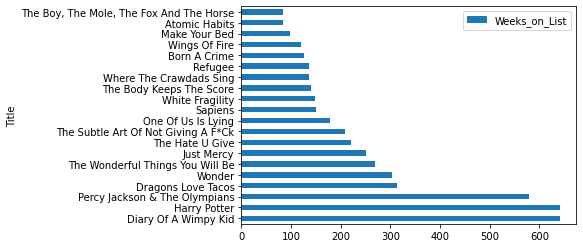

In [78]:
top20 = data.head(20)

data = pd.DataFrame(top20,columns=['Title','Weeks_on_List'])
data.plot(x ='Title', y='Weeks_on_List', kind = 'barh')
plt.show()